In [ ]:
!pip install -q kaggle
!pip install sortedcontainers

In [ ]:
import pandas as pd
import random
from random import randrange
from matplotlib import pyplot as plt
import numpy as np
import sys
import math
from sortedcontainers import SortedList

Download and unzip Kaggle dataset

In [ ]:
 # upload the kaggle.json file provided
 # if doesn't work for some reason see https://www.kaggle.com/general/74235 to create new api key

 from google.colab import files 
 files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ujandeb","key":"9de9f735d28f4c4507a802d6fd74c937"}'}

In [ ]:
# create a directory for the kaggle api key

!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jsrojas/labeled-network-traffic-flows-114-applications
!unzip /content/labeled-network-traffic-flows-114-applications.zip

 98% 353M/362M [00:09<00:00, 19.2MB/s]
100% 362M/362M [00:09<00:00, 39.2MB/s]
Archive:  /content/labeled-network-traffic-flows-114-applications.zip
  inflating: Unicauca-dataset-April-June-2019-Network-flows.csv  


Loading dataset into pandas dataframe

In [ ]:
df = pd.read_csv('/content/Unicauca-dataset-April-June-2019-Network-flows.csv', engine='c')
df.head()

,flow_key,src_ip_numeric,src_ip,src_port,dst_ip,dst_port,proto,pktTotalCount,octetTotalCount,min_ps,max_ps,avg_ps,std_dev_ps,flowStart,flowEnd,flowDuration,min_piat,max_piat,avg_piat,std_dev_piat,f_pktTotalCount,f_octetTotalCount,f_min_ps,f_max_ps,f_avg_ps,f_std_dev_ps,f_flowStart,f_flowEnd,f_flowDuration,f_min_piat,f_max_piat,f_avg_piat,f_std_dev_piat,b_pktTotalCount,b_octetTotalCount,b_min_ps,b_max_ps,b_avg_ps,b_std_dev_ps,b_flowStart,b_flowEnd,b_flowDuration,b_min_piat,b_max_piat,b_avg_piat,b_std_dev_piat,flowEndReason,category,application_protocol,web_service
0,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,22,7620,328,394,346.363636,25.010081,1.555954e+09,1.555955e+09,1701.385427,0.000313,198.656500,81.018354,78.913442,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+12,1701.385427,0.010463,198.657170,106.336589,74.034708,5,1950,389,394,390.000000,2.000000,1.555955e+09,1.555955e+09,1.554399e+12,0.010354,198.657965,51.689181,84.916348,2,Network,Unknown,DHCP
1,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+09,1701.385515,0.010356,198.657267,106.336595,74.034707,17,5670,328,354,333.529412,9.140200,1.555954e+09,1.555955e+12,1701.385515,0.010356,198.657267,106.336595,74.034707,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
2,3acee4f4ea001cd5e6d9584d4036b53d,3232266497,192.168.121.1,67,172.16.255.185,67,17,43,15124,328,394,351.720930,26.098495,1.555964e+09,1.555965e+09,1450.967340,0.000239,248.424737,34.546841,58.972989,30,10062,328,352,335.400000,9.718024,1.555964e+09,1.555965e+12,1450.967340,0.015413,248.424737,50.033357,65.290032,13,5062,389,394,389.384615,1.332347,1.555964e+09,1.555965e+09,1.554409e+12,0.022332,340.268454,89.927588,124.270745,2,Network,Unknown,DHCP
3,974ec5991b439c9a7176b88be0c90df0,3232266497,192.168.121.1,67,172.16.255.186,67,17,30,10086,328,352,336.200000,10.057833,1.555964e+09,1.555965e+09,1450.967130,0.015330,248.424689,50.033349,65.510537,30,10086,328,352,336.200000,10.057833,1.555964e+09,1.555965e+12,1450.967130,0.015330,248.424689,50.033349,65.510537,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,DHCP
4,cfa7c2740072befaa89c202499729e08,3232266497,192.168.121.1,0,10.130.1.166,0,1,1,56,56,56,56.000000,0.000000,1.555966e+09,1.555966e+09,0.000000,0.000000,0.000000,0.000000,0.000000,1,56,56,56,56.000000,0.000000,1.555966e+09,1.555966e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,2,Network,Unknown,ICMP


All the fields of each flow item

In [ ]:
df.columns

Index(['flow_key', 'src_ip_numeric', 'src_ip', 'src_port', 'dst_ip',
       'dst_port', 'proto', 'pktTotalCount', 'octetTotalCount', 'min_ps',
       'max_ps', 'avg_ps', 'std_dev_ps', 'flowStart', 'flowEnd',
       'flowDuration', 'min_piat', 'max_piat', 'avg_piat', 'std_dev_piat',
       'f_pktTotalCount', 'f_octetTotalCount', 'f_min_ps', 'f_max_ps',
       'f_avg_ps', 'f_std_dev_ps', 'f_flowStart', 'f_flowEnd',
       'f_flowDuration', 'f_min_piat', 'f_max_piat', 'f_avg_piat',
       'f_std_dev_piat', 'b_pktTotalCount', 'b_octetTotalCount', 'b_min_ps',
       'b_max_ps', 'b_avg_ps', 'b_std_dev_ps', 'b_flowStart', 'b_flowEnd',
       'b_flowDuration', 'b_min_piat', 'b_max_piat', 'b_avg_piat',
       'b_std_dev_piat', 'flowEndReason', 'category', 'application_protocol',
       'web_service'],
      dtype='object')

Class and function defintions

In [ ]:
class Flow:

  def __init__(self, pktTotalCount, avg_ps, flowDuration, src_ip, dst_ip):
    self.pktTotalCount = pktTotalCount
    self.avg_ps = avg_ps
    self.flowDuration = flowDuration
    self.src_ip = src_ip
    self.dst_ip = dst_ip


class Reservoir:

  def __init__(self):
    self.res = set()
    self.full = False

  def reservoir_size(self):
    return len(self.res)


class KMV:

  def __init__(self):
    self.sortedlist = SortedList()
    self.k = 1000

  def list_size(self):
    return len(self.sortedlist)


# functions

def build_flow(row):
  # extracting the required fields
  pktTotalCount = row['f_pktTotalCount']
  avg_ps = row['f_avg_ps']
  flowDuration = row['flowDuration']
  src_ip = row['src_ip']
  dst_ip = row['dst_ip']
  flow = Flow(pktTotalCount, avg_ps, flowDuration, src_ip, dst_ip)

  return flow


def hash_value(flow):
  # frozenset ignores ordering of tuples
  # this means hash(src, dest) is the same as hash(dest, src)
  fset = frozenset((flow.src_ip, flow.dst_ip))  
  return hash(fset) / sys.maxsize  

Reservoir Sampling 

Implement the reservoir sampling method and maintain 10 reservoirs of size 1000 
flows each. After processing all the flows, plot the histograms of pktTotalCount, avg_ps and flowDuration. Comment if the histograms are similar across the 10 reservoirs (samples). If we use any one of these samples as a batch for SGD algorithm to build a regression model to estimate 
the  data  consumption  by  a  given  user,  how  good  would  it  be?  Can  you  think  of  better  ways  to  make batches in the streaming model for SGD (where memory is constrained)? 

Building a list of reservoirs and filling them

In [ ]:
num_res = 10  # number of reservoirs
res_size = 1000 # size of each reservoir
reservoirs = [] # list to store reservoir objects

for i in range(num_res):  # creating reservoirs to store flows
  reservoirs.append(Reservoir())


# filling the reservoirs upto max capacity

full = False  # check if all reservoirs are full
for index, row in df.iterrows():

  flow = build_flow(row)  # building flow object

  for i in range(num_res + 1):
    if i == num_res:  # all reservoirs full
      full = True
      break
    if not reservoirs[i].full: # ith reservoir has space
      reservoirs[i].res.add(flow) # add flow to reservoir
      if reservoirs[i].reservoir_size() == res_size: 
        reservoirs[i].full = True  # reservoir limit reached
      break

  if full:   # check if all reservoirs are full
    print('All reservoirs full')
    break

# the remaining dataframe
rest = df.iloc[index:, :]

All reservoirs full


Applying reservoir sampling on the rest of the stream

In [ ]:
for index, row in rest.iterrows():

  flow = build_flow(row)  # building flow object

  res_id = randrange(num_res)  # randomly select a reservoir
  size = reservoirs[res_id].reservoir_size()  # current size of reservoir

  n = size + index + 1 
  prob = size / n # s/n

  if random.uniform(0, 1) <= prob:  # keep with probability s/n
    keep = True
  else: keep = False

  if keep:  # keep flow and discard random flow
    el = random.sample(reservoirs[res_id].res, 1)[0]  # randomly select a flow
    reservoirs[res_id].res.remove(el) # discard random flow
    reservoirs[res_id].res.add(flow)  # add flow

Plotting histograms

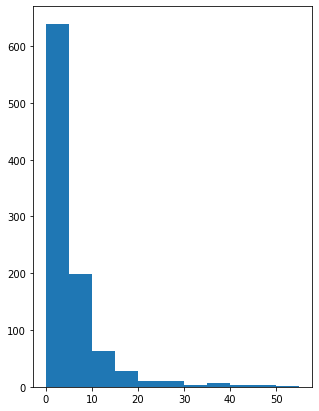

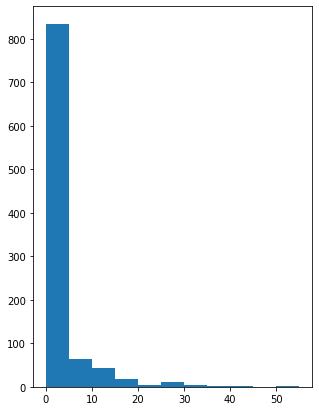

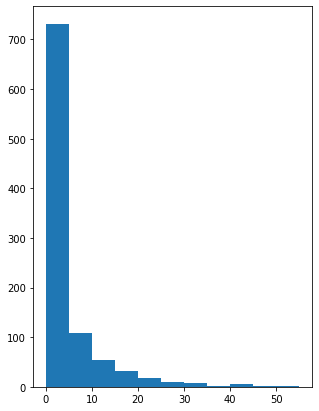

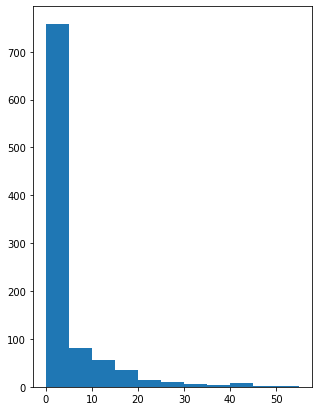

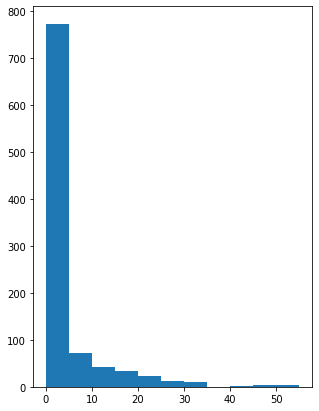

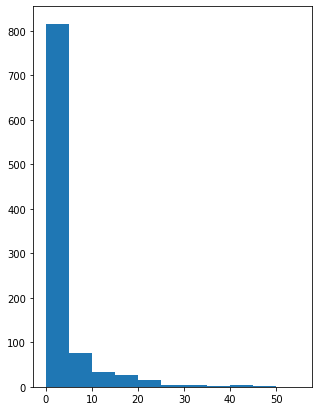

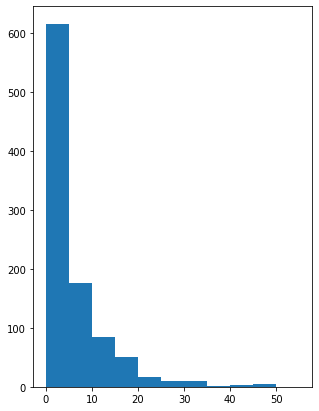

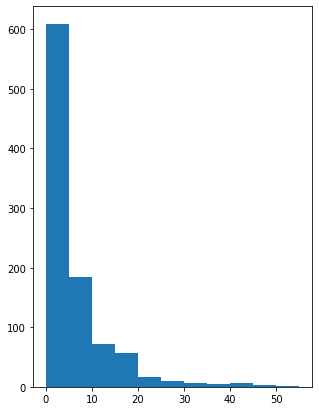

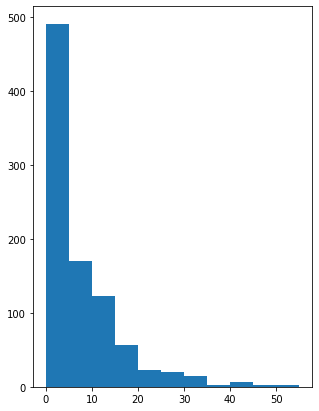

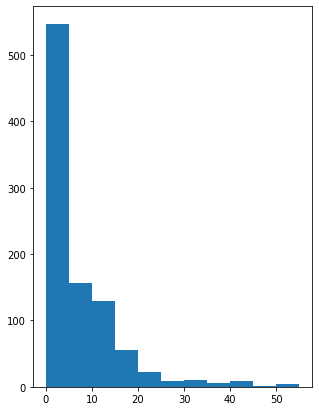

In [ ]:
# pktTotalCount histograms

histograms = []
for i in range(num_res):
  l = []
  for flow in reservoirs[i].res:
    l.append(flow.pktTotalCount)
  a = np.array(l)
  fig, ax = plt.subplots(figsize =(5, 7))
  ax.hist(a, bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55])
  
plt.show()

There are slight differences between the histograms

The current batches are random samples from usage data of all users. A better way to fit a regression model perhaps would be to sample data from a fixed set of users (from the IP addresses) and then use the samples as batches for SGD. 

Estimated Count of the distinct SRC-DST IP Pairs in the dataset using KMV sketch 

Implement the KMV sketch with k=1000. You can use the following implementation for the hash function provided by python. Make sure you finally map the results to interval (0,1) uniformly. For example, you can divide the hash value by the maximum value possible for the hash. You can also control the value of N by taking modulo on the hash. https://docs.python.org/3.7/library/functions.html#hash 

We use a SortedList to simulate a max heap :
https://pypi.org/project/sortedcontainers/

In [ ]:
num_kmv = 10  # number of KMV sketches
kmvs = [] # list to store kmv objects

for i in range(num_kmv):
  kmvs.append(KMV())

for index, row in df.iterrows():

  flow = build_flow(row)
  h = hash_value(flow)
  kmv_id = randrange(num_kmv) # randomly select a KMV sketch

  if kmvs[kmv_id].list_size() < kmvs[kmv_id].k: # sortedlist size less than 1000
    kmvs[kmv_id].sortedlist.add(h)  # add to sortedlist
  elif h < kmvs[kmv_id].sortedlist[-1]:  # sortedlist size reached, check if new hash is less than largest hash value
    kmvs[kmv_id].sortedlist.pop() 
    kmvs[kmv_id].sortedlist.add(h)  # pop largest hash and add new smaller hash

Compute error estimate

In [ ]:
N_hat = []
error = []

# calculate count estimate and error estimate
for i in range(num_kmv):
  n_hat =  - (kmvs[i].k - 1) / kmvs[i].sortedlist[-1] # negative hash values
  N_hat.append(n_hat)
  er = n_hat / math.sqrt(kmvs[i].k - 2)
  error.append(er)

median_est = np.median(np.array(N_hat)) # median estimate
id = np.argsort(np.array(N_hat))[len(np.array(N_hat))//2]
median_err = error[id]  # corresponding error

print('Median distinct count estimate and error (standard deviations) : {}, {}'.format(median_est, median_err))

Median distinct count estimate and error (standard deviations) : 1008.6588804606445, 31.933499785736387


Counting true distincts

In [ ]:
distincts = set()
for index, row in df.iterrows():

  flow = build_flow(row)
  pair = frozenset((flow.src_ip, flow.dst_ip))
  if pair not in distincts:
    distincts.add(pair)

print('True count : {}'.format(len(distincts)))

True count : 310169


Most frequent SRC-DST IP pairs (use MG sketch) 

Implement the MG sketch so that the maximum error in the estimate is no more than 1%. What will be the size of the table? Print out the top 100 most frequent SRC-DST pairs sorted by their estimate frequency (count) after you have processed the whole stream.

In [ ]:
epsilon = 0.01
k = 1 / epsilon # size of table
T = {}  # table as a dictionary

for index, row in df.iterrows():

  flow = build_flow(row)

  pair = frozenset((flow.src_ip, flow.dst_ip))
  if pair in T: T[pair] += 1
  else: T[pair] = 1

  if len(T) > k:
    temp = {}
    for key, value in T.items():
      val = value - 1
      if val > 0: temp[key] = val
    T = temp

In [ ]:
print('Size of table : {}'.format(len(T)))

Size of table : 93


Most frequent SRC-DST pairs sorted by their estimate frequency

In [ ]:
# sorting T by frequencies
s = [(k, v) for k, v in sorted(T.items(), key=lambda item: item[1])]
s.reverse() # since we want the highest frequencies

for i in range(50):
  l = []
  for ip in s[i][0]:
    l.append(ip)
  count = s[i][1]
  print('IP pair and count : {}, {}'.format((l[0], l[1]), count))

IP pair and count : ('192.168.128.3', '172.16.255.200'), 12952
IP pair and count : ('172.16.255.200', '192.168.128.203'), 1739
IP pair and count : ('172.16.255.200', '192.168.128.134'), 489
IP pair and count : ('192.168.128.151', '172.16.255.200'), 434
IP pair and count : ('192.168.128.80', '172.16.255.200'), 431
IP pair and count : ('192.168.128.101', '172.16.255.200'), 264
IP pair and count : ('172.16.255.200', '192.168.127.37'), 248
IP pair and count : ('192.168.128.115', '172.16.255.200'), 166
IP pair and count : ('192.168.128.185', '172.16.255.200'), 90
IP pair and count : ('192.168.128.189', '172.16.141.250'), 85
IP pair and count : ('172.16.255.200', '192.168.128.61'), 82
IP pair and count : ('192.168.128.223', '172.16.141.250'), 74
IP pair and count : ('192.168.128.219', '172.16.141.250'), 73
IP pair and count : ('192.168.128.163', '172.16.255.200'), 69
IP pair and count : ('10.200.7.4', '192.168.128.173'), 63
IP pair and count : ('192.168.128.129', '172.16.255.200'), 55
IP pai